## Data Processing:
1) Load all the subjects

2) Get rid of activityID=0 data

3) Get rid of acc6g and orientation data

4) Use linear interpolation for missing data (including the temeprature)

5) Get rid of the starting and ending 10 sec of each activity

6) Chop the spectra into pieces (t = 3~5 seconds). Each segment overlap the former with 1sec. Make sure that all segment don't across two different activities.

7) Shuffle all spectrum pieces & Split into training and testing data

In [2]:
import dataprocess as dp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1) Load all the subjects

In [3]:
# Load all protocol subjects:
colName=dp.exportColName()
data=dp.loadAllSubjects()

In [5]:
data.tail()

,timestamp,activityID,heart_rate,hand_temp,hand_acc16g_x,hand_acc16g_y,hand_acc16g_z,hand_acc6g_x,hand_acc6g_y,hand_acc6g_z,...,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,ankle_ori_0,ankle_ori_1,ankle_ori_2,ankle_ori_3
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.037788,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.068904,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,...,-0.070888,-0.038024,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,...,0.018961,-0.025796,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029207
2872532,100.23,0,161.0,25.1875,-4.09726,8.15642,3.29961,-4.73244,8.82870,3.54305,...,-0.027472,0.011866,-0.042858,-46.2704,4.21475,0.247798,0.598119,0.033685,0.800188,-0.028602


### 2) Get rid of activityID=0 data

In [6]:
nonZeroData=data.loc[lambda df: df.activityID>0, :].reset_index(drop=True)
nonZeroData.tail()

,timestamp,activityID,heart_rate,hand_temp,hand_acc16g_x,hand_acc16g_y,hand_acc16g_z,hand_acc6g_x,hand_acc6g_y,hand_acc6g_z,...,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,ankle_ori_0,ankle_ori_1,ankle_ori_2,ankle_ori_3
1942867,95.06,24,NaN,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,...,0.021288,-0.012885,0.005878,-45.7855,-0.831734,-0.170139,0.522929,-0.291612,0.705786,-0.378648
1942868,95.07,24,NaN,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,...,0.010715,0.003629,-0.004235,-46.0331,-0.817288,0.538134,0.522880,-0.291694,0.705895,-0.378450
1942869,95.08,24,NaN,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,...,-0.016939,-0.035176,-0.002309,-45.5140,-1.229410,0.540438,0.522625,-0.291978,0.706161,-0.378084
1942870,95.09,24,162.0,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,...,-0.028069,-0.036457,-0.007076,-45.9093,-0.565555,0.680109,0.522536,-0.291955,0.706426,-0.377733
1942871,95.10,24,NaN,25.125,5.00812,5.40645,5.02326,4.97362,5.45272,5.14120,...,-0.013310,-0.030195,0.018229,-46.1702,-0.812965,-0.313346,0.522730,-0.291275,0.706526,-0.377800


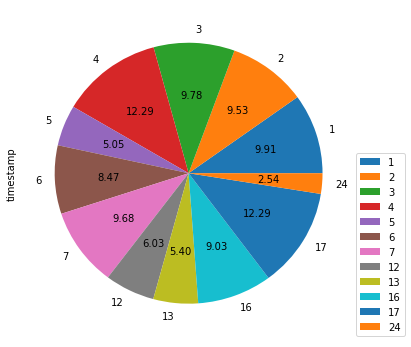

In [17]:
activityAgg=pd.DataFrame(nonZeroData, columns=['timestamp', 'activityID']).groupby('activityID').count()
activityAgg['timestamp'].plot(kind='pie', autopct='%.2f', figsize=[6,6])
plt.legend(loc=(1,0), labels=activityAgg.index);

### 3) Get rid of acc6g and orientation data

In [18]:
colToDrop=['hand_acc6g_x', 'hand_acc6g_y', 'hand_acc6g_z', 'hand_ori_0', 'hand_ori_1', 'hand_ori_2', 'hand_ori_3', 
           'chest_acc6g_x', 'chest_acc6g_y', 'chest_acc6g_z', 'chest_ori_0', 'chest_ori_1', 'chest_ori_2', 'chest_ori_3', 
           'ankle_acc6g_x', 'ankle_acc6g_y', 'ankle_acc6g_z', 'ankle_ori_0', 'ankle_ori_1', 'ankle_ori_2', 'ankle_ori_3']
effectiveData=nonZeroData.drop(colToDrop, axis=1)

In [19]:
effectiveData.tail()

,timestamp,activityID,heart_rate,hand_temp,hand_acc16g_x,hand_acc16g_y,hand_acc16g_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,...,ankle_temp,ankle_acc16g_x,ankle_acc16g_y,ankle_acc16g_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z
1942867,95.06,24,NaN,25.125,4.99466,6.01881,5.59830,-0.289166,-0.110170,0.238570,...,31.5,9.40727,-2.24401,-2.25974,0.021288,-0.012885,0.005878,-45.7855,-0.831734,-0.170139
1942868,95.07,24,NaN,25.125,5.02764,5.90369,5.48372,-0.275411,-0.128358,0.267409,...,31.5,9.36745,-2.28110,-2.33710,0.010715,0.003629,-0.004235,-46.0331,-0.817288,0.538134
1942869,95.08,24,NaN,25.125,5.06409,5.71370,5.48491,-0.289885,-0.126548,0.281483,...,31.5,9.36765,-2.24313,-2.33734,-0.016939,-0.035176,-0.002309,-45.5140,-1.229410,0.540438
1942870,95.09,24,162.0,25.125,5.13914,5.63724,5.48629,-0.234417,-0.101485,0.275497,...,31.5,9.44470,-2.24425,-2.25936,-0.028069,-0.036457,-0.007076,-45.9093,-0.565555,0.680109
1942871,95.10,24,NaN,25.125,5.00812,5.40645,5.02326,-0.260924,-0.093849,0.266205,...,31.5,9.44670,-2.28286,-2.18192,-0.013310,-0.030195,0.018229,-46.1702,-0.812965,-0.313346


### 4) Use linear interpolation for missing data (including the temeprature)

In [140]:
filledData = effectiveData.interpolate(method='linear', axis=0).ffill().bfill()
filledData.tail()

,timestamp,activityID,heart_rate,hand_temp,hand_acc16g_x,hand_acc16g_y,hand_acc16g_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,...,ankle_temp,ankle_acc16g_x,ankle_acc16g_y,ankle_acc16g_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z
1942867,95.06,24,162.0,25.125,4.99466,6.01881,5.59830,-0.289166,-0.110170,0.238570,...,31.5,9.40727,-2.24401,-2.25974,0.021288,-0.012885,0.005878,-45.7855,-0.831734,-0.170139
1942868,95.07,24,162.0,25.125,5.02764,5.90369,5.48372,-0.275411,-0.128358,0.267409,...,31.5,9.36745,-2.28110,-2.33710,0.010715,0.003629,-0.004235,-46.0331,-0.817288,0.538134
1942869,95.08,24,162.0,25.125,5.06409,5.71370,5.48491,-0.289885,-0.126548,0.281483,...,31.5,9.36765,-2.24313,-2.33734,-0.016939,-0.035176,-0.002309,-45.5140,-1.229410,0.540438
1942870,95.09,24,162.0,25.125,5.13914,5.63724,5.48629,-0.234417,-0.101485,0.275497,...,31.5,9.44470,-2.24425,-2.25936,-0.028069,-0.036457,-0.007076,-45.9093,-0.565555,0.680109
1942871,95.10,24,162.0,25.125,5.00812,5.40645,5.02326,-0.260924,-0.093849,0.266205,...,31.5,9.44670,-2.28286,-2.18192,-0.013310,-0.030195,0.018229,-46.1702,-0.812965,-0.313346


### 5) Remove the starting and ending 10 sec (=1000 timestamp data points) of each activity

In [141]:
actID = filledData.activityID.unique()

# Create a dictionary to store the dataframes of each activity:
actDict = {}
for a in actID:
    actDict[a] = filledData.loc[lambda df: df.activityID==a, :].reset_index(drop=True)

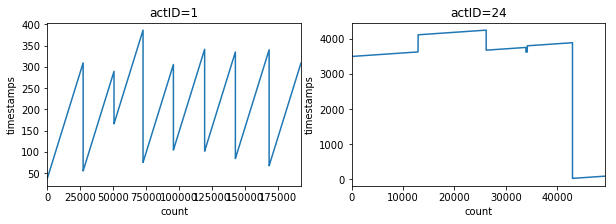

In [142]:
plt.figure(figsize=[10, 3])
plt.subplot(121)
actDict[1].timestamp.plot(kind='line')
plt.ylabel('timestamps')
plt.xlabel('count')
plt.title('actID=1')
plt.subplot(122)
actDict[24].timestamp.plot(kind='line')
plt.ylabel('timestamps')
plt.xlabel('count')
plt.title('actID=24')
plt.tight_layout;

In [143]:
### Return indices that show timestamp discondinuity:
def findTimeDiscontinuity(actDF):
    time = actDF.timestamp
    tgap = np.where(abs(np.array(time[1:])-np.array(time[:-1]))>0.015)[0]
    return tgap
    

### Remove the head and tail of the activity from each subject ###
# dt=10 means to kill 10sec-long of data
def throwHeadAndTail(actDF, dt=10):
    # find indices that show timestamp discondinuity:
    tgap = findTimeDiscontinuity(actDF)
    n = dt*100
    
    indToDrop = np.linspace(0, n-1, n)
    for t in range(len(tgap)):
        indToDrop = np.append(indToDrop, np.linspace(tgap[t]-(n-1), tgap[t]+n, 2*n))
    # Need to take care of the case like act24. Use np.unique().
    indToDrop = np.unique(np.append(indToDrop, np.linspace(len(actDF.timestamp)-n, len(actDF.timestamp)-1, n)).astype(int))
    
    df = actDF.copy()
    df = df.drop(df.index[indToDrop]).reset_index(drop=True)
    return df

In [129]:
findTimeDiscontinuity(actDict[24])

array([12911, 26173, 33906, 34162, 42968], dtype=int64)

Alright! Seems to match the discontinuities in the above act24 figure.

In [158]:
# Create a NEW dictionary to store the data for all activities:
actMiddleDict = {}
for a in actID:
    actMiddleDict[a] = throwHeadAndTail(actDict[a])

In [159]:
actMiddleDict[3].head()

,timestamp,activityID,heart_rate,hand_temp,hand_acc16g_x,hand_acc16g_y,hand_acc16g_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,...,ankle_temp,ankle_acc16g_x,ankle_acc16g_y,ankle_acc16g_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z
0,554.33,3,109.0,32.6875,2.75280,8.78785,3.55403,-0.040774,-0.004593,0.028803,...,33.0625,9.95341,-0.325150,-0.529522,-0.033548,0.034116,-0.034787,-85.7297,38.4361,-4.88286
1,554.34,3,109.0,32.6875,2.86108,8.82357,3.40158,-0.036145,-0.005093,0.007957,...,33.0625,9.79651,-0.436179,-0.761979,-0.015298,-0.011559,0.007370,-86.1884,38.9000,-5.36928
2,554.35,3,109.0,32.6875,2.78390,8.78588,3.36207,-0.002676,-0.001491,-0.004023,...,33.0625,9.76168,-0.360648,-0.685626,0.010672,0.026647,0.018825,-85.2855,38.8585,-4.63444
3,554.36,3,109.0,32.6875,2.85895,8.70942,3.36345,-0.040941,0.041601,0.006060,...,33.0625,9.76939,-0.362896,-0.415406,-0.020622,0.011766,-0.030237,-85.5076,38.6473,-4.75865
4,554.37,3,109.0,32.6875,2.74772,8.82445,3.39988,-0.073068,0.014401,0.010611,...,33.0625,9.72476,-0.474638,-0.646708,-0.010747,0.025472,-0.008813,-85.5060,38.3212,-5.13348


### 6) Chop the spectra into pieces (t = 5.12 seconds). Each segment overlap the former with 1sec.

In [205]:
### Return a 3D narray with many small chuncks of data ###
# duration = 5.12 sec
def chopSpectrumWithT(dataframe, duration=5.12):
    t = int(duration*100)
    N = len(dataframe)
    db = []
    for i in range(int(N/100)):
        if (i*100+t < N) and (dataframe.timestamp[i*100+t]-dataframe.timestamp[i*100]<duration+0.1):
            db.append(np.array(dataframe.loc[i*100:i*100+t-1, :]))
    return np.array(db)


### Check if there is any data in the 3D array whose timestamp is not continuous ###
# Should return 0 if segregate the data properly.
def discontinuityCount(db):
    t=db.shape[1]
    return np.array([(db[i][t-1][0]-db[i][0][0])>(t/100+0.1) for i in range(len(db))]).astype(int).sum()


### Similar to chapSpectrumWithT but remove timestamp and activity ID ###
def chopSpectrum(dataframe, duration=5.12):
    t = int(duration*100)
    N = len(dataframe)
    db = []
    for i in range(int(N/100)):
        if (i*100+t < N) and (dataframe.timestamp[i*100+t]-dataframe.timestamp[i*100]<duration+0.1):
            db.append(np.array(dataframe.loc[i*100:i*100+t-1, 'hand_temp':]))
    return np.array(db)

In [206]:
print('Discontinuity count for all activities:')
for a in actID:
    db=chopSpectrumWithT(actMiddleDict[a], duration=5.12)
    print(a, '\t', discontinuityCount(db))

Discontinuity count for all activities:
1 	 0
2 	 0
3 	 0
17 	 0
16 	 0
12 	 0
13 	 0
4 	 0
7 	 0
6 	 0
5 	 0
24 	 0


**Now I'm going to create a dictionary that stores segments from different activities with respect to their activityID. These segments are the data that we are going to train the model.**

In [207]:
dataDict = {}
for a in actID:
    dataDict[a] = chopSpectrum(actMiddleDict[a], duration=5.12)

**Number of data points for each activity from all subjects:**

In [214]:
for a in np.sort(actID):
    n, t, f = dataDict[a].shape
    print('actID={} has {} short segments with t={}, feature number={}'.format(a, n, t, f))

actID=1 has 1761 short segments with t=512, feature number=31
actID=2 has 1687 short segments with t=512, feature number=31
actID=3 has 1735 short segments with t=512, feature number=31
actID=4 has 2218 short segments with t=512, feature number=31
actID=5 has 847 short segments with t=512, feature number=31
actID=6 has 1496 short segments with t=512, feature number=31
actID=7 has 1726 short segments with t=512, feature number=31
actID=12 has 808 short segments with t=512, feature number=31
actID=13 has 660 short segments with t=512, feature number=31
actID=16 has 1589 short segments with t=512, feature number=31
actID=17 has 2222 short segments with t=512, feature number=31
actID=24 has 374 short segments with t=512, feature number=31
